<p style="text-align:center">
    <a href="https://www.ict.mahidol.ac.th/en/" target="_blank">
    <img src="https://www3.ict.mahidol.ac.th/ICTSurveysV2/Content/image/MUICT2.png" width="400" alt="Faculty of ICT">
    </a>
</p>

# Lab07: ML Basics: Regression

This tutorial will provide hands-on practice in building regression models to predict using the real-world Melbourne House Prices dataset collected in 2017, by using multiple features from the dataset and including evaluating model performance using two error metrics. 

Furthermore, it will introduce key machine learning concepts such as feature engineering, model complexity trade-off to improve the error scores. You will learn how to expand feature sets, create polynomial features, interpret coefficients, assess feature importance; which will lead us towards smart algorithms that can manage this trade-off. The steps will show you how to use utilize core machine learning concepts including pipelines and cross-validation for robust model training and evaluation.


## This tutorial will look at regression predictions (numeric outputs):
* Create an interactive GIS map of the dataset, using Plotly.
* Re-evaluate the (X) Distance -> Price (Y) prediction model. Measure its MAE and R² error scores.
* See the effects of underfitting to the data in learning curves (due to a simple model), therefore we will increase model complexity.
* Complexify our approach by expanding:
    * (1) the number of features,
    * Introduce a plot to show the model's error per feature (residual error plots with 0 error as the red line).
    * (2) the feature representations using Polynomial equations to increase the number of model parameters, and the estimator function's expressiveness to the data.
    * (3) find this can overfit our training data (via learning curves) at the expense of our testing data fit.
    * Therefore we will need to choose smart algorithms when we complexify (which you will do shortly).
* In the Lab 07 Assignment, you will use a smarter (more sophisticated) algorithm to model and predict the data, then display its predictions.

Also:
* Look at interpreting feature coefficients (with multi-feature / multivariate linear regression).
* Look at feature importance - the importance of each feature upon the predictions, by scaling.
* Introduce new concepts:
    * Pipelines to handle scaling preprocessing steps "automagically";
    * Cross-validation (CV K-folds) to calculate the learning curves, which will give an average error across the full dataset by evaluating several times.

__Instructions:__
1. Append your ID at the end of this jupyter file name. For example, ```ITCS227_Lab07_Assignment_6788123.ipynb```
2. Complete each task in the lab.
3. Once finished, raise your hand to call a TA.
4. The TA will check your work and give you an appropriate score.
5. Submit the source code to MyCourse as record-keeping.

In [38]:
# Plotly is installed with Anaconda, if you need to install it seperately, see https://pypi.org/project/plotly/
# Shap Values is installed separately, see: https://pypi.org/project/shap/
# !pip install plotly shap

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

## 1. Load the dataset with a Numeric Target (Dataset for Regression)

###### Diabetes Dataset (Optional extra for your own investigation):

**Diabetes Dataset Description**

* Ten baseline variables, age, sex, body mass index, average blood pressure, and six blood serum measurements were obtained for each of n = 442 diabetes patients, as well as the response of interest, a quantitative measure of disease progression one year after baseline.

Data Set Characteristics:

* Number of Instances: 442
* Number of Attributes: First 10 columns are numeric predictive values
* Target: Column 11 is a quantitative measure of disease progression one year after baseline

Attribute Information:

* age age in years
* sex
* bmi body mass index
* bp average blood pressure
* s1 tc, total serum cholesterol
* s2 ldl, low-density lipoproteins
* s3 hdl, high-density lipoproteins
* s4 tch, total cholesterol / HDL
* s5 ltg, possibly log of serum triglycerides level
* s6 glu, blood sugar level

Note: Each of these 10 feature variables have been mean centered and scaled by the standard deviation times the square root of n_samples (i.e. the sum of squares of each column totals 1).

Response Attribute Information:

* For our tutorial, we will interpret:
  * `y=0` value to mean there is no disease progression after 1 year.
  * `y>0` means there has been a degree of disease progression (larger numbers mean larger progression).

Source URL: https://www4.stat.ncsu.edu/~boos/var.select/diabetes.html

For more information see: Bradley Efron, Trevor Hastie, Iain Johnstone and Robert Tibshirani (2004) “Least Angle Regression,” Annals of Statistics (with discussion), 407-499. (https://web.stanford.edu/~hastie/Papers/LARS/LeastAngle_2002.pdf)

In [40]:
from sklearn.datasets import load_diabetes
# Load a dataset
data = load_diabetes(scaled=False)
df = pd.DataFrame(data.data, columns=data.feature_names)
df['y'] = data.target # y = "measure of disease progression one year after baseline"

features = ['bmi'] #  # Use only one feature: bmi - Body Mass Index
target = ['y']

print("Original DataFrame Info:")
print(df.info())
print('Note: y is the target, which is a "Measure of disease progression, one year after baseline measurement."')
print('We will interpret a `y=0` value to mean there is no disease progression after 1 year. Whereas a `y>0` means there has been progression.')

Original DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     442 non-null    float64
 1   sex     442 non-null    float64
 2   bmi     442 non-null    float64
 3   bp      442 non-null    float64
 4   s1      442 non-null    float64
 5   s2      442 non-null    float64
 6   s3      442 non-null    float64
 7   s4      442 non-null    float64
 8   s5      442 non-null    float64
 9   s6      442 non-null    float64
 10  y       442 non-null    float64
dtypes: float64(11)
memory usage: 38.1 KB
None
Note: y is the target, which is a "Measure of disease progression, one year after baseline measurement."
We will interpret a `y=0` value to mean there is no disease progression after 1 year. Whereas a `y>0` means there has been progression.


In [41]:
print('Number of Records,  Features: ', df.shape)
print('Head of dataframe, for two example records:')
display(df.head(2))

Number of Records,  Features:  (442, 11)
Head of dataframe, for two example records:


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,y
0,59.0,2.0,32.1,101.0,157.0,93.2,38.0,4.0,4.8598,87.0,151.0
1,48.0,1.0,21.6,87.0,183.0,103.2,70.0,3.0,3.8918,69.0,75.0


### Melbourne House Prices Dataset: (2017)

Melbourne real estate is BOOMING. Can you find the insight or predict the next big trend to become a real estate mogul… or even harder, to snap up a reasonably priced 2-bedroom unit?

**Content**
- This is a snapshot of a dataset created by Tony Pino.
- It was scraped from publicly available results posted every week from Domain.com.au. He cleaned it well, and now it's up to you to make data analysis magic. The dataset includes Address, Type of Real estate, Suburb, Method of Selling, Rooms, Price, Real Estate Agent, Date of Sale and distance from C.B.D.

**Notes on Specific Variables**
- Rooms: Number of rooms
- Price: Price in dollars
- Method: S - property sold; SP - property sold prior; PI - property passed in; PN - sold prior not disclosed; SN - sold not disclosed; NB - no bid; VB - vendor bid; W - withdrawn prior to auction; SA - sold after auction; SS - sold after auction price not disclosed. N/A - price or highest bid not available.
- Type: br - bedroom(s); h - house,cottage,villa, semi,terrace; u - unit, duplex; t - townhouse; dev site - development site; o res - other residential.
- SellerG: Real Estate Agent
- Date: Date sold
- Distance: Distance from CBD
- Regionname: General Region (West, North West, North, North east …etc)
- Propertycount: Number of properties that exist in the suburb.
- Bedroom2 : Scraped # of Bedrooms (from different source)
- Bathroom: Number of Bathrooms
- Car: Number of carspots
- Landsize: Land Size
- BuildingArea: Building Size
- CouncilArea: Governing council for the area

**Acknowledgements**
- This is intended as a static (unchanging) snapshot of https://www.kaggle.com/anthonypino/melbourne-housing-market. It was created in September 2017. Additionally, homes with no Price have been removed.

In [42]:
import plotly.express as px
import plotly.io as pio
def TIMESTAMP_FILENAME(): return time.strftime("%Y-%m-%d_%H-%M")
    
def plotly_map(df, latlng_cols=('lat','lng'), z=None, custom_data_cols=[], custom_text=[], center_dict=dict(lat=13.6, lon=100.4), zoom=5, WRITE=False, WRITE_FN=None):
    """ 
    @WRITE_FN - do not include extension - i.e. `.png` or `.html`, as both files will be written.
    Docs:   https://plotly.com/python-api-reference/generated/plotly.express.density_mapbox.html
            https://plotly.com/python/mapbox-density-heatmaps/
    """
    pio.templates.default = 'plotly_white' # 'plotly_dark'
    fig = px.density_mapbox(df, 
                            lat=latlng_cols[0], 
                            lon=latlng_cols[1], 
                            z=z,
                            radius=5,
                            center=center_dict, zoom=zoom,
                            mapbox_style=["open-street-map",'carto-darkmatter'][0],
                            custom_data=custom_data_cols,
                           )

    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    if custom_text:
        fig.update_traces(
            hovertemplate="<br>".join(custom_text)
        )
    fig.show(config={'displayModeBar': False} )
    if WRITE:
        if WRITE_FN != None and isinstance(WRITE_FN, str) and len(WRITE_FN)>4:
            ofn = f'{WRITE_FN}_MapPlot_{TIMESTAMP_FILENAME()}'
            fig.write_image(ofn+'.png')
            fig.write_html(ofn+'.html', full_html=False, include_plotlyjs=False, include_mathjax=False )

#### Exploration Code:

In [43]:
# Load a real-world dataset (using the small-sampled Melbourne Housing dataset)
try:
    df = pd.read_csv('files/melb_data.csv').drop('Unnamed: 0',axis=1) # Try to use the local file
except FileNotFoundError:
    print("melb_data.csv not found locally.")

print("Original DataFrame Info:")
print(df.info())

cols_to_use = ['Distance','Landsize','BuildingArea','Rooms', 'Bathroom', 'Price']

print('Total Num of Records ',len(df))
df.head()

Original DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18396 entries, 0 to 18395
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         18396 non-null  object 
 1   Address        18396 non-null  object 
 2   Rooms          18396 non-null  int64  
 3   Type           18396 non-null  object 
 4   Price          18396 non-null  float64
 5   Method         18396 non-null  object 
 6   SellerG        18396 non-null  object 
 7   Date           18396 non-null  object 
 8   Distance       18395 non-null  float64
 9   Postcode       18395 non-null  float64
 10  Bedroom2       14927 non-null  float64
 11  Bathroom       14925 non-null  float64
 12  Car            14820 non-null  float64
 13  Landsize       13603 non-null  float64
 14  BuildingArea   7762 non-null   float64
 15  YearBuilt      8958 non-null   float64
 16  CouncilArea    12233 non-null  object 
 17  Lattitude      15064 non-

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra,-37.7996,144.9984,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.8079,144.9934,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra,-37.8093,144.9944,Northern Metropolitan,4019.0
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,...,2.0,1.0,94.0,NaN,NaN,Yarra,-37.7969,144.9969,Northern Metropolitan,4019.0
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,...,1.0,2.0,120.0,142.0,2014.0,Yarra,-37.8072,144.9941,Northern Metropolitan,4019.0


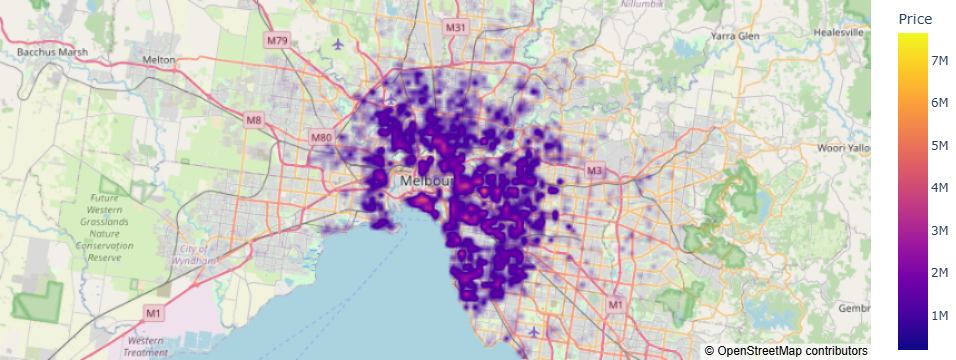

In [44]:
dfm = df.dropna() # Drop NaNs for the visualization:
plotly_map(dfm[ (dfm['Method']=='S') ] , 
           # Method: S - property sold ~~ This includes properties that were sold, and therefore includes its price at the time of sale.
           # You could easily add more Pandas filters here to explore the data, such as dfm[ (dfm['Method']=='S') & (dfm['Price']<1000000)] 
           latlng_cols=('Lattitude','Longtitude'), 
           z='Price',
           custom_data_cols=['CouncilArea',
                             'Distance',
                             'Landsize',
                             'BuildingArea',
                             'Rooms',
                             'Bathroom',
                             'Price'
                           ], 
           custom_text=['Area: %{customdata[0]}',
                        'Distance: %{customdata[1]}',
                        'LS  / BA: %{customdata[2]}/%{customdata[3]}',
                        'Bed / Bath: %{customdata[4]}/%{customdata[5]}',
                        'Price AUD-$: %{customdata[6]:.,1f}'
                            ],
           center_dict=dict(lat=-37.814, lon=144.963),
           zoom=9
          )

```



```
## 2. X -> Y Dataset Split:

First we collect the `X` (inputs) and `y` (outputs) from the complete dataset.

#### Get X-Y Data with Imputed Missing Values:
- Fill in the missing values in the dataset, the `NaN` and `None` values. This only works for `numerical` features.
    - `MICE` - **(Multivariate Imputation from Chained Equations):**
        - This time we will use `MICE` to impute any missing values in the dataset, feature by feature.
        - `MICE` works by predicting a Feature 1 (e.g. distance), according to the remaining features, (e.g. Bedrooms, Bathrooms, Land Size, etc.).
            - For Feature 1, the MICE algorithm will look at all the remaining features (as X), and try to predict the best value to replace a missing value in feature 1 (as Y_Pred).
            - The dataset already contains many Y_True values (for Feature 1). Because of this, most values are filled in.
            - So MICE trains a regression model on the known Y_True values and only predicts the missing Y (Feature 1) values to insert (impute) into the dataset.
            - It is possible to measure the impact of any imputation algorithm, by comparing `End-to-End Machine Learning task's` prediction results for different imputation methods.
            - (Learn more on this topic in an Advanced Statistics subject.)

In [45]:
import pandas as pd
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

def get_some_data(data:pd.DataFrame, features:list, target:list):
    y = data[target].to_numpy()
    X = data[features].to_numpy()
    imp = IterativeImputer(max_iter=10, random_state=0)
    imputed_X = imp.fit(X).transform(X) # This uses MICE - Multivariate Imputation from Chained Equations.
                                        # Multivariate imputer that estimates each feature from all the others. 
                                        # A strategy for imputing missing values by modeling each feature with 
                                        # missing values as a function of other features in a round-robin fashion.
    return imputed_X, y
    

In [46]:
print("First, let's separate the X features from the Y target feature(s)\n")

target = ['Price']
features = cols_to_use[:-1]

X, y = get_some_data( df, features, target )

y_min = y.min()
y_max = y.max()

print(f"X shape: {X.shape}, y shape: {y.shape}")
print(f'X : {features}')
print(f'y : {target}')
print(f'{target} - Target feature value range (Min-Max): {y_min:,.1f}-{y_max:,.1f}')
display(df[features+target].describe())

First, let's separate the X features from the Y target feature(s)

X shape: (18396, 5), y shape: (18396, 1)
X : ['Distance', 'Landsize', 'BuildingArea', 'Rooms', 'Bathroom']
y : ['Price']
['Price'] - Target feature value range (Min-Max): 85,000.0-9,000,000.0


,Distance,Landsize,BuildingArea,Rooms,Bathroom,Price
count,18395.000000,13603.000000,7762.000000,18396.000000,14925.000000,1.839600e+04
mean,10.389986,558.116371,151.220219,2.935040,1.538492,1.056697e+06
std,6.009050,3987.326586,519.188596,0.958202,0.689311,6.419217e+05
min,0.000000,0.000000,0.000000,1.000000,0.000000,8.500000e+04
25%,6.300000,176.500000,93.000000,2.000000,1.000000,6.330000e+05
50%,9.700000,440.000000,126.000000,3.000000,1.000000,8.800000e+05
75%,13.300000,651.000000,174.000000,3.000000,2.000000,1.302000e+06
max,48.100000,433014.000000,44515.000000,12.000000,8.000000,9.000000e+06


#### Train/ Test Splits:
Later, we will split the full dataset into `train set` and `test set`.

In Lab 7, we will be using two new techniques:
* `Feature Scaling of X` and
* `K-folds Cross Validation` to make the `Train/ Test split` "auto-magically" (we can learn more detail about how this works and why it is great for evaluating models later on).

Each time we `fit / predict` a model to `(1) train` and `(2) test (or evaluate)` the **estimator function** - our model we will handle the spliting. As before, the `test set` will represent how our model might perform on real-world input data.

So, at this stage we only have `X` and `y`

```







```
## 3. Linear Regression Fit/Predict:


### 3.1 Univariate (Single Feature) Number Prediction:

Last week we used only `Distance->Price` (`X->Y`) to get a prediction.

Let's repeat that and collect the errors summary to remind ourselves.

In [47]:
def _extract_model_parameters(estimator, features):
    intercept = estimator.intercept_[0]
    coefficients = estimator.coef_[0]
    
    print("Intercept:", intercept)
    print("Coefficients:", list(coefficients))
    sf = 1
    
    model_params = [coefficients, intercept]
    coef_strings = [f'{round(tup[0],sf):,.1f} * X{tup[1]}({tup[2]})' for tup in zip(model_params[0], range(1,len(features)+1), features ) ]
    eq = f'{model_params[1]:,.1f} + '+(' + '.join( coef_strings ))+f" ({sf} s.f.)"
    eq = f'f( X ) = {eq}'
    return eq

In [48]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

X, y = get_some_data( df, ['Distance'], target )
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0) # Split into 85% training and 15% testing data

estimator = LinearRegression()
estimator.fit(X_train, y_train)
input_to_predict =  X_train[0].reshape(1, -1)
y_pred = estimator.predict( input_to_predict )
y_true = y_train[0]
error = y_true - y_pred
print(f'For this data-point {dict(zip(features,input_to_predict[0]))} in the Price prediction (estimate) had an AUD $ {error[0][0]:,.2f} (error)')
# Take out the integer value (from the numpy arrays. In this case, the value is wrapped by two arrays, hence [0][0])

For this data-point {'Distance': 11.2} in the Price prediction (estimate) had an AUD $ -423,601.66 (error)


* Let's measure Mean Absolute Error again, to get the average prediction price error in AUD-$.

* Let's also introduce $R^2$ (R-squared or R^2):
    > R-squared represents the proportion of the variance in our target (`Price feature`) that is predictable from the input variables (`X features`).
    >    - `R2= 0.70`  -- Means -- `70% of variation` in `Price` is explained by the estimator function trained on the input `X features`.
    >    - However, `30% remains unexplained`.

In [49]:
from sklearn.metrics import mean_absolute_error, r2_score
y_pred = estimator.predict(X_test)
print(f"mean_absolute_error: {mean_absolute_error(y_test, y_pred):,.2f}")
print(f"r2_score: {r2_score(y_test, y_pred):,.2f}")


mean_absolute_error: 455,330.98
r2_score: 0.03


In [50]:
# print("Here's the estimator function found by Linear Regression: \n")
# _extract_model_parameters(estimator, features)

### 3.2 Plot individual Error Distances:

* Another look at error distances for each point, to decide if some inputs (X) to the model perform better than others.
* Mostly we are interested in the `Test set` performance results.

In [51]:
def _plot_regression_distance_errors( X_set, y_set, estimator, input_feature_name='' ):
    y_pred = estimator.predict( X_set )
    # Plot data and individual distance errors
    plt.figure(figsize=(8, 5))
    for i in range(len(X_set)):
        plt.plot([X_set[i], X_set[i]], [y_set[i], y_pred[i]], color="gray", lw=0.75, linestyle="dashed")
    plt.scatter(X_set, y_set, color="blue", label="Actual values", s=10)
    plt.plot(X_set, y_pred, color="red", label="Regression line")
    
    # Plot individual errors as vertical lines
    plt.xlabel(f"Input {input_feature_name} (X)")
    plt.ylabel("Target (y)")
    plt.title(f"Linear Regression with Individual Errors (n={len(X_set):,})")
    plt.legend()
    plt.grid(True)
    from matplotlib.lines import Line2D
    error_line = Line2D([], [], color='gray', linestyle='--', lw=0.5, label='Error distance per point')
    plt.legend(handles=[*plt.gca().get_legend_handles_labels()[0], error_line])
    plt.show()

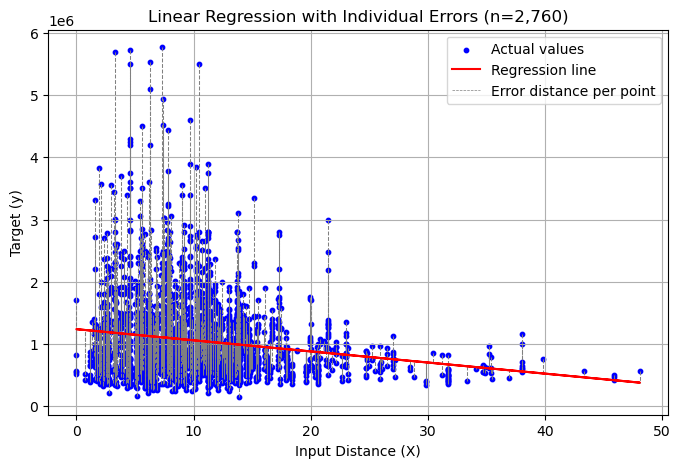

In [52]:
_plot_regression_distance_errors( X_test, y_test, estimator, input_feature_name=features[0] )

## 4. Learning Curves

The goal of the `learning curve` plot is to visualize whether the model algorithm is `overfitting` or `underfitting` the dataset.

Then we can decide the next step to improve the model: either to `simplify` or `complexify`.

**How this works?**

Fit/ Predict the model on different sizes of the dataset, to see how the models performs. Alternatively, if using mini-batch learning then we measure error per epoch or training cycle (such as neural network training or the SGDRegressor).
- If the error line is falling as data size increase (`X-axis`), then more data may continue to improve model performance.
- If the error line is stationary and `Train / Valid` are approx equal and the error is high,
    - Then the model is `underfitting`
- If the error line is stationary and `Train / Valid` are approx equal and the error is low,
    - The model is `generalized`.
- If the error line for `Train` is lower than `Valid`,
    - The model is `overfitting` the training data.

In [53]:
def _plot_learning_curve(estimator, train_sizes, train_scores, valid_scores, metric='MAE', plt_text='', ax=None):
    train_errors = -train_scores.mean(axis=1)
    valid_errors = -valid_scores.mean(axis=1)
    ax = plt.gca() if not ax else ax
    ax.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
    ax.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")
    ax.set_xlabel("Training set size")
    ax.set_ylabel(f'{metric}')
    # plt.gca().set_xscale("log", nonpositive='clip')
    ax.grid()
    ax.legend(loc="upper right")
    ax.set_ylim(bottom=0, top=1.25*max([max(train_errors), max(valid_errors)]))
    ax.set_title(f'{estimator.__class__.__name__}\n{plt_text}', fontsize=8)

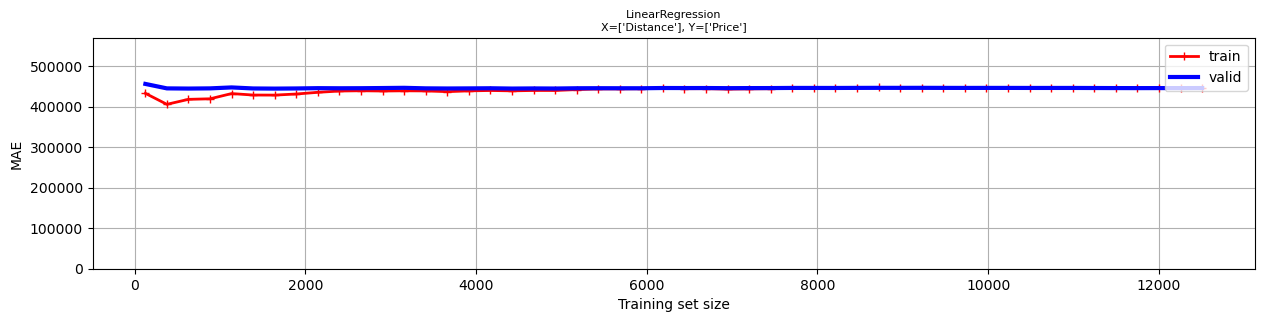

In [54]:
from sklearn.model_selection import learning_curve # New - for evaluating errors and then visualizing later.
from sklearn.preprocessing import StandardScaler   # New - for preprocessing.
from sklearn.pipeline import Pipeline              # New - used to preprocess and fit/predict data automatically and correctly, handled by SciKit Learn.

X, y = get_some_data( df, ['Distance'], target )
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0) # Split into 85% training and 15% testing data

estimator = LinearRegression()
pipeline = Pipeline([
    # ('scaler', StandardScaler()),  # StandardScaler
    ('regressor', estimator)       # Regressor estimator
])

train_sizes, train_scores, valid_scores = learning_curve( pipeline, 
                                                        X_train, y_train, 
                                                        train_sizes=np.linspace(0.01, 1.0, 50), # 50 size intervals, from 1% to 100%
                                                        cv=5,     # CV=5 means  Train = 80%  , Test = 20%.
                                                                  # CV=10 means Train = 90%  , Test = 10%.
                                                                  #   - The fit/predict is repeated 5 times with random samples taken from X/Y.
                                                                  #   - The resulting error is the average across all 5 trials; so a smoother and fairer result than CV=1 , which is hold-out.
                                                        scoring="neg_mean_absolute_error"
                                                    )

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 3), sharey=True, sharex=True)
_plot_learning_curve(estimator, train_sizes, train_scores, valid_scores, plt_text=f'X={["Distance"]}, Y={target}', ax=ax)


### 4.1 Making a decision:
* The LinearRegression model with a single `X` feature will `underfit` almost all non-trivial datasets.
* The `R2 Score at 0.03` shows the model can explain 3% of the dataset's price.
* The `MAE` metric shows `half-a-million-dollars` error on average for predictions.
* The `error analysis plot` above shows wide errors on the 5-15 KM distance properties.

All of this information suggests the model is `underfitting` the dataset. So we will `complexify` the modelling process in the next step.

Also see the table in the slides for decision actions for `underfit` and `overfit`.

```



```

## 5. `Complexify` Model / Features:


Our options for `underfitting` are:
1. Increase number of features
2. Increase feature representation (embeddings / feature engineering)
3. Increase model complexity


## 6. Increase number of features
### 6.1 Multiple Feature Number Prediction: (Multivariate Linear Regression)

This week we will use more than a single feature `[x1,x2,x3,...]->Price` (`X->Y`) to get a prediction.

Let's just try that and collect the errors summary as an initial comparison.

In [55]:
def _evaluate_estimator_1( estimator, X_train, X_test, y_train, y_test, features ):
    estimator.fit(X_train, y_train)
    input_to_predict =  X_train[0].reshape(1, -1)
    y_pred = estimator.predict( input_to_predict )
    y_true = y_train[0]
    error = y_true - y_pred
    print(f'For this data-point {dict(zip(features,input_to_predict[0]))} in the Price prediction (estimate) had an AUD $ {error[0][0]:,.2f} (error)')
    # Take out the integer value (from the numpy arrays. In this case, the value is wrapped by two arrays, hence [0][0])
    y_pred = estimator.predict(X_test)
    print(f"Test: mean_absolute_error: {mean_absolute_error(y_test, y_pred):,.2f}")
    print(f"Test: r2_score: {r2_score(y_test, y_pred):,.2f}")
    return estimator

In [56]:
X, y = get_some_data( df, features, target )
estimator = LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1) # Split into 85% training and 15% testing data

estimator = _evaluate_estimator_1( estimator, X_train, X_test, y_train, y_test, features )

For this data-point {'Distance': 5.5, 'Landsize': 573.0, 'BuildingArea': 186.0, 'Rooms': 4.0, 'Bathroom': 2.0} in the Price prediction (estimate) had an AUD $ 532,600.47 (error)
Test: mean_absolute_error: 355,693.71
Test: r2_score: 0.40


* Adding the extra features `improved the MAE and R2 summary error metrics` and it reduced the specific error for our 1 data-point trial at `Distance=11.2`.

In [57]:
print("----------------\nHere's the estimator function found by Linear Regression:")
eq = _extract_model_parameters(estimator, features)
print(eq)

----------------
Here's the estimator function found by Linear Regression:
Intercept: 206393.33742288023
Coefficients: [-34622.19415795447, -4.502157005612961, 33.16216577719159, 298824.82638205675, 213770.2633763773]
f( X ) = 206,393.3 + -34,622.2 * X1(Distance) + -4.5 * X2(Landsize) + 33.2 * X3(BuildingArea) + 298,824.8 * X4(Rooms) + 213,770.3 * X5(Bathroom) (1 s.f.)


```




```
#### Add Scaler into Pipeline:
- *(Pipeline evaluation functions)*

In [58]:
from sklearn.model_selection import cross_validate, KFold
from sklearn.pipeline import Pipeline

def _fit_cv_eval_pipeline(pipeline, X_train, y_train,
                        preferred_metric='neg_mean_squared_error', kfolds=5, random_state=0 ):
    
    kf = KFold(n_splits=kfolds, shuffle=True, random_state=random_state)
    cv_scores = cross_validate( pipeline,
                                X_train, y_train,
                                cv=kf,
                                scoring=preferred_metric,
                                error_score='raise',
                                return_estimator=True)
    min_index = np.argmin(cv_scores['test_score'])
    best_cv_pipeline = cv_scores['estimator'][min_index]
    #y_pred = best_cv_pipeline.predict(X_test) # Get best from K-folds set.
    pipeline.fit(X_train, y_train) # Refit the model on the entire dataset.
    return cv_scores, best_cv_pipeline, pipeline

def _evaluate_pipeline_2( pipeline, X_train, X_test, y_train, y_test, features ):
    pipeline.fit(X_train, y_train)
    input_to_predict = X_train[0].reshape(1, -1)
    input_to_predict_transformed = pipeline.named_steps['scaler'].transform(input_to_predict)
    y_pred = pipeline.predict( input_to_predict )
    y_true = y_train[0]
    error = y_true - y_pred
    print(f'For this data-point {dict(zip(features,input_to_predict[0]))} in the Price prediction (estimate) had an AUD $ {error[0][0]:,.2f} (error)')
    print(f' - Transformed inputs: {dict(zip(features,input_to_predict_transformed[0]))}')
    # Take out the integer value (from the numpy arrays. In this case, the value is wrapped by two arrays, hence [0][0])
    X_test_transformed = pipeline.named_steps['scaler'].transform(X_test)
    y_pred = pipeline.predict(X_test)
    print(f"mean_absolute_error: {mean_absolute_error(y_test, y_pred):,.2f}")
    print(f"r2_score: {r2_score(y_test, y_pred):,.2f}")
    return pipeline

In [59]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

X, y = get_some_data( df, features, target )
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1) # Split into 85% training and 15% testing data

estimator = LinearRegression()
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # StandardScaler
    ('regressor', estimator)       # Regressor estimator
])

_, _, pipeline = _fit_cv_eval_pipeline(pipeline, X_train, y_train)
_ = _evaluate_estimator_1( pipeline, X_train, X_test, y_train, y_test, features )

For this data-point {'Distance': 5.5, 'Landsize': 573.0, 'BuildingArea': 186.0, 'Rooms': 4.0, 'Bathroom': 2.0} in the Price prediction (estimate) had an AUD $ 532,600.47 (error)
Test: mean_absolute_error: 355,693.71
Test: r2_score: 0.40


In [60]:
pipeline = _evaluate_pipeline_2( pipeline, X_train, X_test, y_train, y_test, features )
pip_estimator = pipeline.named_steps['regressor']

For this data-point {'Distance': 5.5, 'Landsize': 573.0, 'BuildingArea': 186.0, 'Rooms': 4.0, 'Bathroom': 2.0} in the Price prediction (estimate) had an AUD $ 532,600.47 (error)
 - Transformed inputs: {'Distance': -0.8168827615671893, 'Landsize': 0.0034201487374309705, 'BuildingArea': 0.018836903878375513, 'Rooms': 1.1154171033002909, 'Bathroom': 0.7245479258774505}
mean_absolute_error: 355,693.71
r2_score: 0.40


In [61]:
print("----------------\nHere's the estimator function found by Linear Regression:")
eq = _extract_model_parameters(pip_estimator, features)
print(eq)

----------------
Here's the estimator function found by Linear Regression:
Intercept: 1053619.58633922
Coefficients: [-207497.98898114523, -16658.878723485428, 33065.00630448356, 286083.0727374571, 137479.6473104587]
f( X ) = 1,053,619.6 + -207,498.0 * X1(Distance) + -16,658.9 * X2(Landsize) + 33,065.0 * X3(BuildingArea) + 286,083.1 * X4(Rooms) + 137,479.6 * X5(Bathroom) (1 s.f.)


### 6.2 Residual Error Plot of Price (Y) Error Distances:

In [62]:

def _plot_regression_distance_errors2( X_set, y_set, pipeline):

    y_pred = pipeline.predict( X_set )
    residuals = y_set - y_pred
    
    X_list = np.array([i for i in range(len(X_set))]).reshape(len(X_set), 1)
    zeroes = np.array([0 for i in range(len(X_set))]).reshape(len(X_set), 1)
    # Plot data and individual distance errors
    plt.figure(figsize=(15, 5))
    for i in X_list:
        plt.plot([X_list[i][0], X_list[i][0]], [zeroes[i][0], residuals[i][0]], color="gray", lw=0.75, linestyle="dashed")
    plt.scatter(X_list, residuals, color="blue", label="Error values", s=10)
    plt.plot(X_list, zeroes, color="red", label="Zero Error line")
    
    # Plot individual errors as vertical lines
    plt.xlabel("Input # (X)")
    plt.ylabel("Residual Error (of Target (y))")
    plt.title(f"Regression Model with Residual Errors (n={len(X_set):,})")
    plt.legend()
    plt.grid(True)
    from matplotlib.lines import Line2D
    error_line = Line2D([], [], color='gray', linestyle='--', lw=0.5, label='Error distance per point')
    plt.legend(handles=[*plt.gca().get_legend_handles_labels()[0], error_line])
    plt.show()


def _plot_regression_distance_errors3( X_set, y_set, pipeline, features, feature_idx=0):

    y_pred = pipeline.predict( X_set )
    residuals = y_set - y_pred

    # Sort by the selected feature
    feature_name = features[feature_idx]
    sorted_indices = np.argsort(X_set[:, feature_idx])  # Sort based on feature index
    X_sorted = X_set[sorted_indices]  
    y_sorted = y_set[sorted_indices]
    residuals_sorted = residuals[sorted_indices]
    
    X_list = X_sorted[:, feature_idx].reshape(len(X_set), 1)
    zeroes = np.zeros_like(X_list).reshape(len(X_set), 1)
    # Plot data and individual distance errors
    plt.figure(figsize=(15, 3))
    for i in range(len(X_list)):
        plt.plot([X_list[i][0], X_list[i][0]], [zeroes[i][0], residuals_sorted[i][0]], color="gray", lw=0.75, linestyle="dashed")
    plt.scatter(X_list, residuals_sorted, color="blue", label="Error values", s=10)
    plt.plot(X_list, zeroes, color="red", label="Zero Error line")
    
    # Plot individual errors as vertical lines
    plt.xlabel(f"{feature_name} Value (X)")
    plt.ylabel("Residual Error (of Target (y))")
    plt.title(f"Regression Model with Residual Errors for {feature_name} (n={len(X_set):,})")
    plt.legend()
    plt.grid(True)
    from matplotlib.lines import Line2D
    error_line = Line2D([], [], color='gray', linestyle='--', lw=0.5, label='Error distance per point')
    plt.legend(handles=[*plt.gca().get_legend_handles_labels()[0], error_line])
    plt.show()

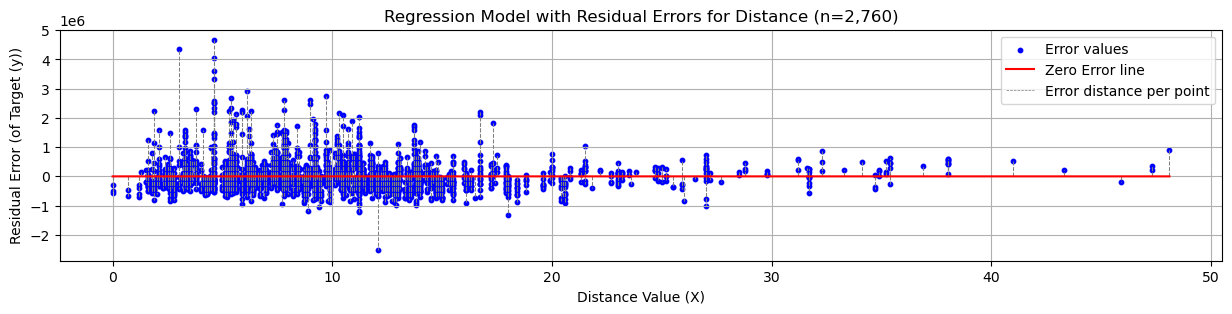

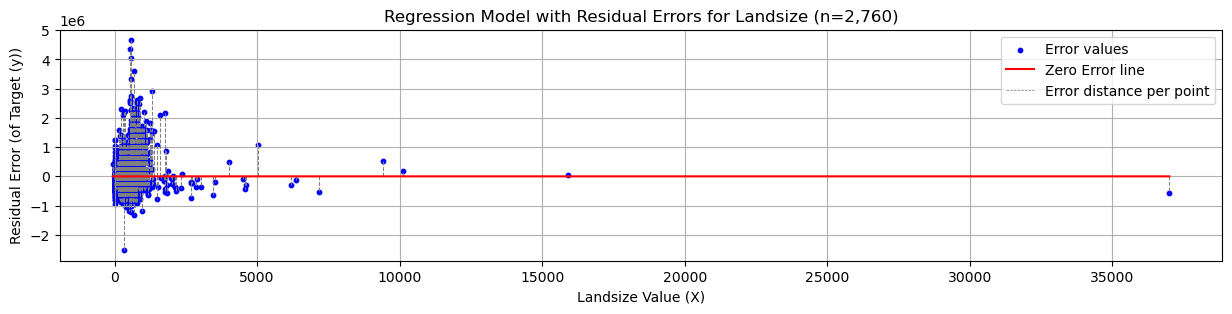

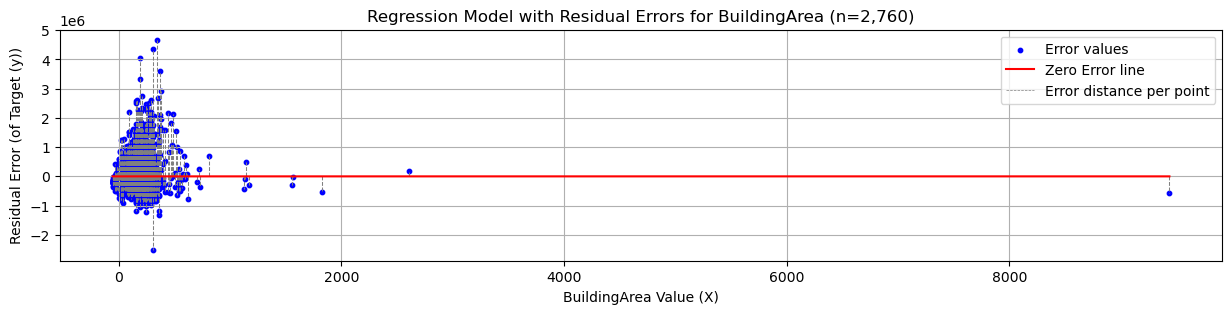

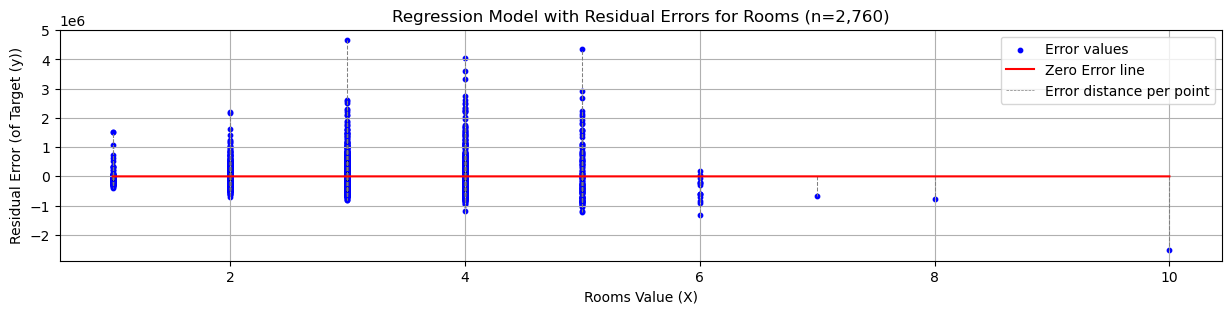

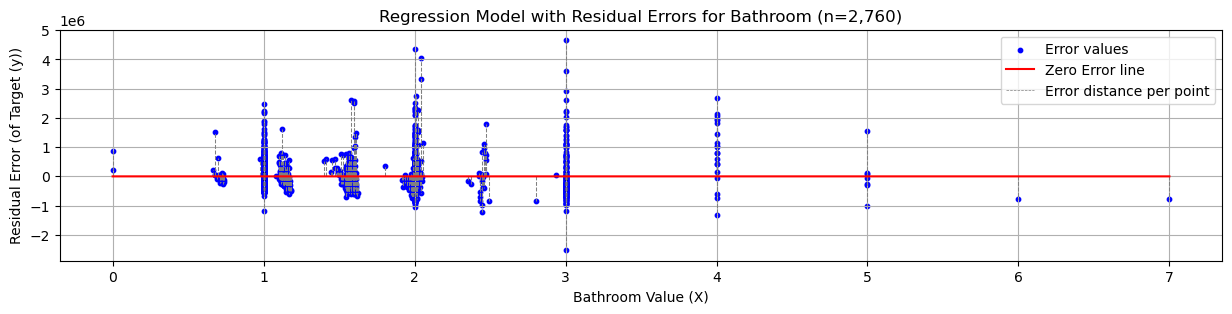

In [63]:
for i,_ in enumerate(features):
    _plot_regression_distance_errors3( X_test, y_test, pipeline, features, feature_idx=i  )

```















```
## 7. Further Increase Number of Features:

We can add even more features to check its impact on improving the model.

* Adding more features will probably help.
* Let's also check the `feature importance` of each `X` feature, to help us understand which are best at predicting the Price `Y`.

In [64]:
X, y = get_some_data( df, features+['YearBuilt','Bedroom2'], target )
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1) # Split into 85% training and 15% testing data

estimator = LinearRegression()
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # StandardScaler
    ('regressor', estimator)       # Regressor estimator
])

_, _, pipeline = _fit_cv_eval_pipeline(pipeline, X_train, y_train)

_ = _evaluate_estimator_1( pipeline, X_train, X_test, y_train, y_test, features+['YearBuilt','Bedroom2'] )

For this data-point {'Distance': 5.5, 'Landsize': 573.0, 'BuildingArea': 186.0, 'Rooms': 4.0, 'Bathroom': 2.0, 'YearBuilt': 1890.0, 'Bedroom2': 5.0} in the Price prediction (estimate) had an AUD $ 141,750.43 (error)
Test: mean_absolute_error: 339,011.15
Test: r2_score: 0.42


In [65]:
pipeline = _evaluate_pipeline_2( pipeline, X_train, X_test, y_train, y_test, features+['YearBuilt','Bedroom2'] )
pip_estimator = pipeline.named_steps['regressor']
print("----------------\nHere's the estimator function found by Linear Regression:")
eq = _extract_model_parameters(pip_estimator, features)
print(eq)

For this data-point {'Distance': 5.5, 'Landsize': 573.0, 'BuildingArea': 186.0, 'Rooms': 4.0, 'Bathroom': 2.0, 'YearBuilt': 1890.0, 'Bedroom2': 5.0} in the Price prediction (estimate) had an AUD $ 141,750.43 (error)
 - Transformed inputs: {'Distance': -0.8168828341472152, 'Landsize': 0.0025821674544989196, 'BuildingArea': 0.019533389014161944, 'Rooms': 1.1154171033002909, 'Bathroom': 0.7246194082613955, 'YearBuilt': -1.2081933614515952, 'Bedroom2': 2.2039754794043427}
mean_absolute_error: 339,011.15
r2_score: 0.42
----------------
Here's the estimator function found by Linear Regression:
Intercept: 1053619.586339226
Coefficients: [-136629.56082287928, -51263.633040274806, 413525.0740829037, 164589.27322243527, 197272.81599266775, -389228.44325836713, 28710.775153010836]
f( X ) = 1,053,619.6 + -136,629.6 * X1(Distance) + -51,263.6 * X2(Landsize) + 413,525.1 * X3(BuildingArea) + 164,589.3 * X4(Rooms) + 197,272.8 * X5(Bathroom) (1 s.f.)


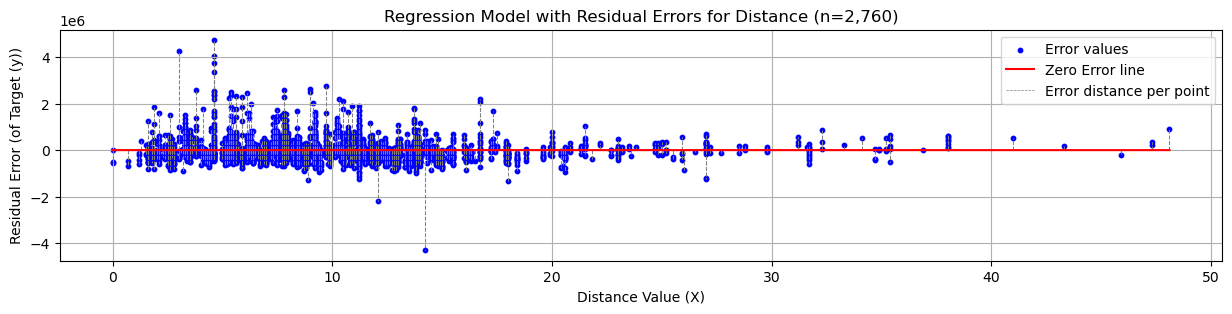

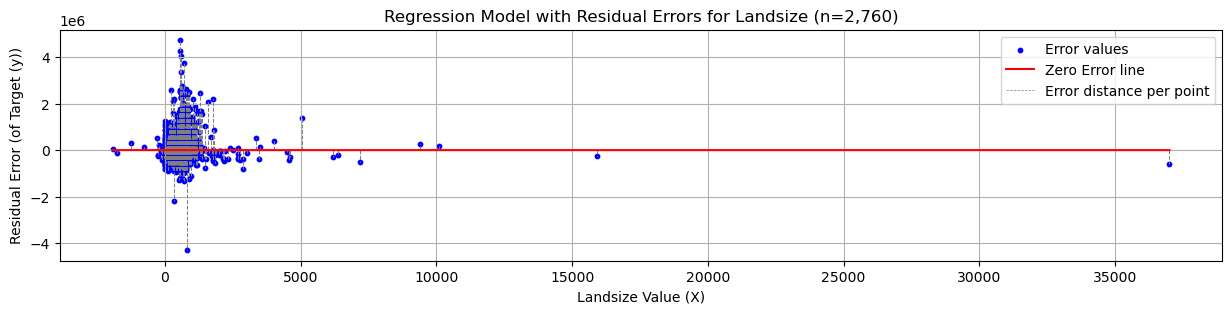

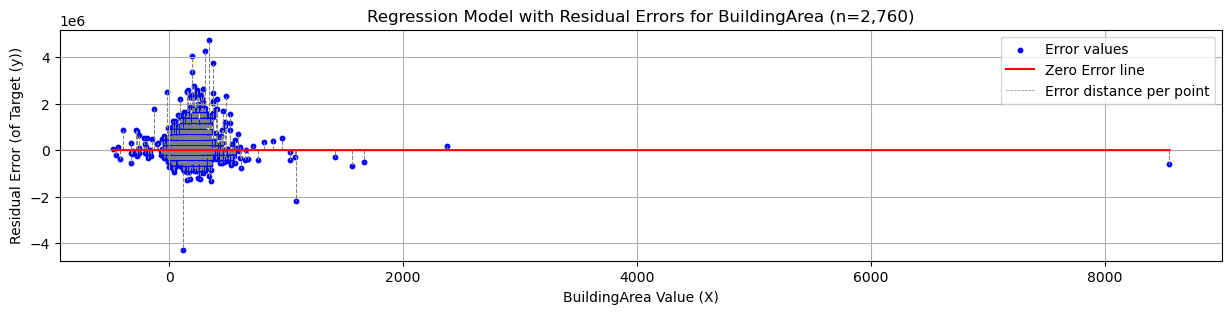

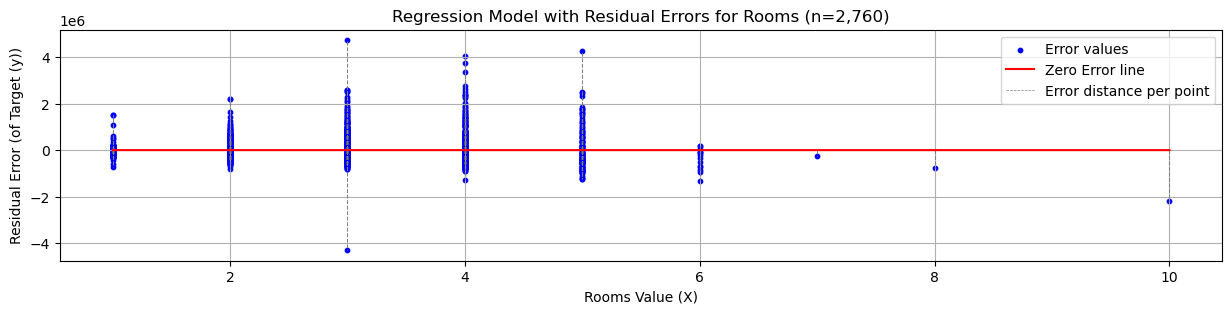

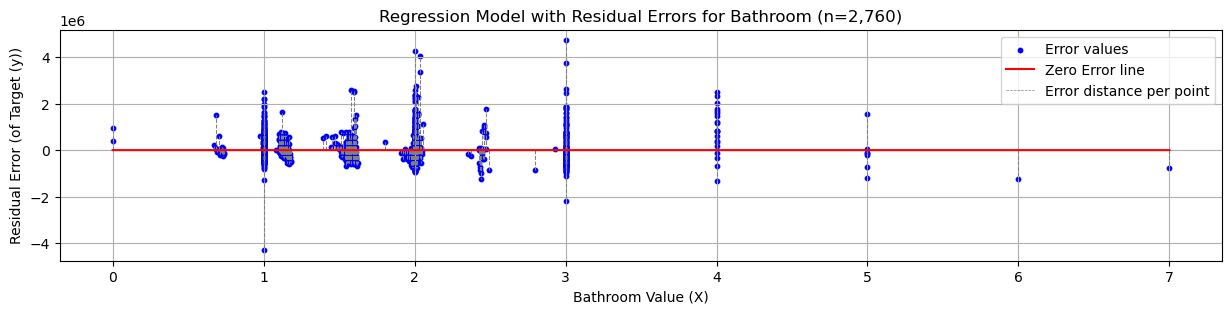

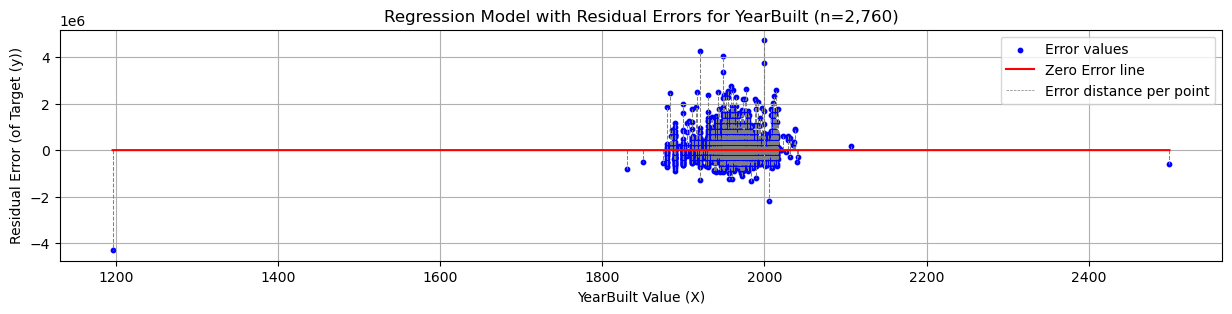

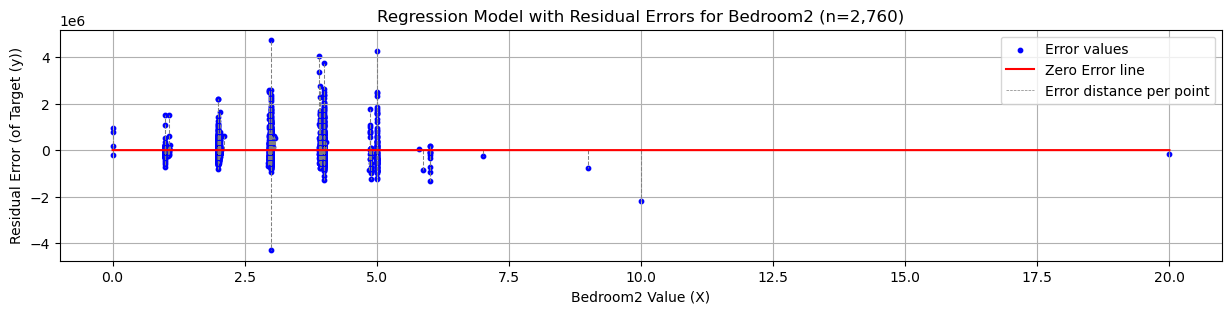

In [66]:
for i,_ in enumerate(features+['YearBuilt','Bedroom2']):
    _plot_regression_distance_errors3( X_test, y_test, pipeline, features+['YearBuilt','Bedroom2'], feature_idx=i  )

In [67]:
def display_feature_importance( pipeline, feature_names ):
    # Extract absolute coefficients as feature importance
    coefficients = np.abs(pipeline.named_steps['regressor'].coef_[0])
    
    # Create a DataFrame for reporting feature importance
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance (abs coef)': coefficients
    }).sort_values(by="Importance (abs coef)", ascending=False)
    
    display(feature_importance_df)

In [68]:
from sklearn.preprocessing import RobustScaler

X, y = get_some_data( df, features+['YearBuilt','Bedroom2'], target )

scaler = RobustScaler()
X_prescaled = scaler.fit_transform(X)

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X_prescaled, y, test_size=0.15, random_state=1) # Split into 85% training and 15% testing data

In [70]:
estimator = LinearRegression()
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # StandardScaler
    ('regressor', estimator)       # Regressor estimator
])

_, _, pipeline = _fit_cv_eval_pipeline(pipeline, X_train, y_train)

display_feature_importance( pipeline, feature_names=features+['YearBuilt','Bedroom2'] )

,Feature,Importance (abs coef)
2,BuildingArea,413525.074083
5,YearBuilt,389228.443258
4,Bathroom,197272.815993
3,Rooms,164589.273222
0,Distance,136629.560823
1,Landsize,51263.633040
6,Bedroom2,28710.775153


* The ranked features are shown above. Top is most important for predicting the Price `Y` target.
* The large coefficients are not so easily `interpretable` (as they are now in Standard-Deviation Unit scale). They are still large, because the Price predication value is large.
* Adding `YearBuilt` was valuable. It is ranked number 2.
* Adding `Bedroom2` was less valuable (less important) according to the variance in Price explained by the feature.

### 7.2 Extras - Feature Importance Plots: SHAP Summary Plot:

We can also plot the feature importance visually, according to the `RobustScaled` and `StandardScaled` model. We can use the `Shap` library for this.

In [71]:
import shap

def _display_shap_plots(pipeline, X_train, feature_names):    
    # Initialize SHAP explainer
    explainer = shap.Explainer(pipeline.named_steps['regressor'], X_train)
    # Compute SHAP values
    shap_values = explainer(X_train)
    # Summary plot (shows feature importance)
    shap.summary_plot(shap_values, X_train, feature_names, show=False)
    plt.gcf().set_size_inches(7,3)
    plt.title('Summary Plot', fontsize=9)
    plt.gca().tick_params(axis='both', labelsize=9)
    plt.gca().tick_params(axis='both', labelsize=9)
    plt.xlabel(plt.gca().get_xlabel(),fontsize=9)
    plt.ylabel(plt.gca().get_ylabel(),fontsize=9)
    plt.show()

ModuleNotFoundError: No module named 'shap'

The Summary Plot of Features is produced below. It is a scatter plot showing how each feature affects predictions, according to its `shap value`.

* Intuitively, these `shap-value` `dots` show the average contribution of a specific feature to a model's prediction.
    * i.e.
        * A `positive shap-value` shows the feature `increases Price`.
        * A `negative shap-value` shows the feature `decreases Price`.
    * Red = higher feature values, Blue = lower feature values.
    * Features are ranked by importance (top = most important).

In [ ]:
# _display_shap_plots(pipeline, X_train, feature_names=features+['YearBuilt','Bedroom2'])

* Mostly High (red) values of `YearBuilt` decrease the Price.
* Mostly High (red) values of `BuildingArea` increase the Price.
* The most valuable aspect is the scale of effect, so the top-ranked features have the most positive impact.

```















```
## 8. Increase model parameters and feature representation (embeddings / feature engineering): - Polynomial Linear Regression:

We can further improve model performance by modifying the feature representations. This is partly feature engineering and is a data preprocessing step.

* We will use polynomial feature expansion.
* 👉 However, this approach has a `specific drawback` - It will `overfit` the training data. Because of this problem, `all new algorithms have much cleverer solutions to solve this problem than Polynomials`.
* 👉 This underlying drawback is `the key reason why we use more sophisticated algorithms for most predictive modelling tasks`. (You will see those in later weeks and later in your studies).

👉 Let's take a look (and find the breaking point!)

### 8.1 - 1 Degree Polynomial

In [72]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

X, y = get_some_data( df, features+['YearBuilt','Bedroom2'], target )
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1) # Split into 85% training and 15% testing data
estimator = LinearRegression()
pipeline = Pipeline([
    ('poly', PolynomialFeatures(degree=1, include_bias=False)),
    ('scaler', StandardScaler()),  # StandardScaler
    ('regressor', estimator)       # Regressor estimator
])

_, _, pipeline = _fit_cv_eval_pipeline(pipeline, X_train, y_train)
_ = _evaluate_estimator_1( pipeline, X_train, X_test, y_train, y_test, features+['YearBuilt','Bedroom2'] )

y_pred = pipeline.predict(X_train)
print(f"Train: mean_absolute_error: {mean_absolute_error(y_train, y_pred):,.2f}")
print(f"Train: r2_score: {r2_score(y_train, y_pred):,.2f}")

print("----------------")
print("Has ", len(pipeline.named_steps['regressor'].coef_[0])+1, 'parameters')
print("Has ", X.shape[1], 'features')

For this data-point {'Distance': 5.5, 'Landsize': 573.0, 'BuildingArea': 186.0, 'Rooms': 4.0, 'Bathroom': 2.0, 'YearBuilt': 1890.0, 'Bedroom2': 5.0} in the Price prediction (estimate) had an AUD $ 141,750.43 (error)
Test: mean_absolute_error: 339,011.15
Test: r2_score: 0.42
Train: mean_absolute_error: 327,484.27
Train: r2_score: 0.42
----------------
Has  8 parameters
Has  7 features


### 8.1 - >1 Degree Polynomial

In [73]:
def _eval_poly_degree(deg=2, features=[], target=[]):
    X, y = get_some_data( df, features, target )
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1) # Split into 85% training and 15% testing data
    estimator = LinearRegression()
    pipeline = Pipeline([
        ('poly', PolynomialFeatures(degree=deg, include_bias=False)),
        ('scaler', StandardScaler()),  # StandardScaler
        ('regressor', estimator)       # Regressor estimator
    ])
    
    _, _, pipeline = _fit_cv_eval_pipeline(pipeline, X_train, y_train)
    _ = _evaluate_estimator_1( pipeline, X_train, X_test, y_train, y_test, features+['YearBuilt','Bedroom2'] )
    
    y_pred = pipeline.predict(X_train)
    print(f"Train: mean_absolute_error: {mean_absolute_error(y_train, y_pred):,.2f}")
    print(f"Train: r2_score: {r2_score(y_train, y_pred):,.2f}")
    print("----------------")
    print("Has ", len(pipeline.named_steps['regressor'].coef_[0])+1, 'parameters')
    print("Has ", X.shape[1], 'features')
    return pipeline


In [74]:
for i in range(1,4):
    print('-------\n Polynomial degree:',i,':')
    pip = _eval_poly_degree(i, features+['YearBuilt','Bedroom2'], target)

-------
 Polynomial degree: 1 :
For this data-point {'Distance': 5.5, 'Landsize': 573.0, 'BuildingArea': 186.0, 'Rooms': 4.0, 'Bathroom': 2.0, 'YearBuilt': 1890.0, 'Bedroom2': 5.0} in the Price prediction (estimate) had an AUD $ 141,750.43 (error)
Test: mean_absolute_error: 339,011.15
Test: r2_score: 0.42
Train: mean_absolute_error: 327,484.27
Train: r2_score: 0.42
----------------
Has  8 parameters
Has  7 features
-------
 Polynomial degree: 2 :
For this data-point {'Distance': 5.5, 'Landsize': 573.0, 'BuildingArea': 186.0, 'Rooms': 4.0, 'Bathroom': 2.0, 'YearBuilt': 1890.0, 'Bedroom2': 5.0} in the Price prediction (estimate) had an AUD $ -48,177.16 (error)
Test: mean_absolute_error: 323,713.60
Test: r2_score: 0.43
Train: mean_absolute_error: 310,820.42
Train: r2_score: 0.47
----------------
Has  36 parameters
Has  7 features
-------
 Polynomial degree: 3 :
For this data-point {'Distance': 5.5, 'Landsize': 573.0, 'BuildingArea': 186.0, 'Rooms': 4.0, 'Bathroom': 2.0, 'YearBuilt': 1890.

### 8.1 - >1 Degree Polynomial & Overfitting

In [75]:
def _plot_learning_curve_poly1( pipeline, X_train, y_train, plt_text='' ):
    train_sizes, train_scores, valid_scores = learning_curve(
        pipeline, 
        X_train, y_train, 
        train_sizes=np.linspace(0.5, 1.0, 50), 
        cv=5,
        scoring="neg_mean_absolute_error"
    )
    _plot_learning_curve(pipeline, train_sizes, train_scores, valid_scores, metric='MAE', plt_text=plt_text)

-------
 Polynomial degree: 1 :
For this data-point {'Distance': 5.5, 'Landsize': 573.0, 'BuildingArea': 186.0, 'Rooms': 4.0, 'Bathroom': 2.0, 'YearBuilt': 1890.0, 'Bedroom2': 5.0} in the Price prediction (estimate) had an AUD $ 141,750.43 (error)
Test: mean_absolute_error: 339,011.15
Test: r2_score: 0.42
Train: mean_absolute_error: 327,484.27
Train: r2_score: 0.42
----------------
Has  8 parameters
Has  7 features


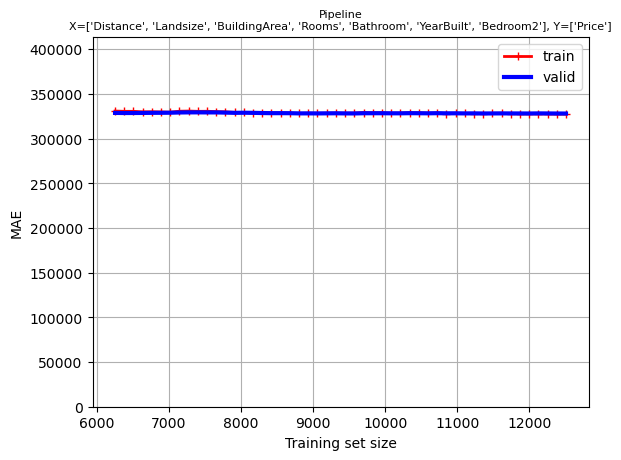

-------
 Polynomial degree: 2 :
For this data-point {'Distance': 5.5, 'Landsize': 573.0, 'BuildingArea': 186.0, 'Rooms': 4.0, 'Bathroom': 2.0, 'YearBuilt': 1890.0, 'Bedroom2': 5.0} in the Price prediction (estimate) had an AUD $ -48,177.16 (error)
Test: mean_absolute_error: 323,713.60
Test: r2_score: 0.43
Train: mean_absolute_error: 310,820.42
Train: r2_score: 0.47
----------------
Has  36 parameters
Has  7 features


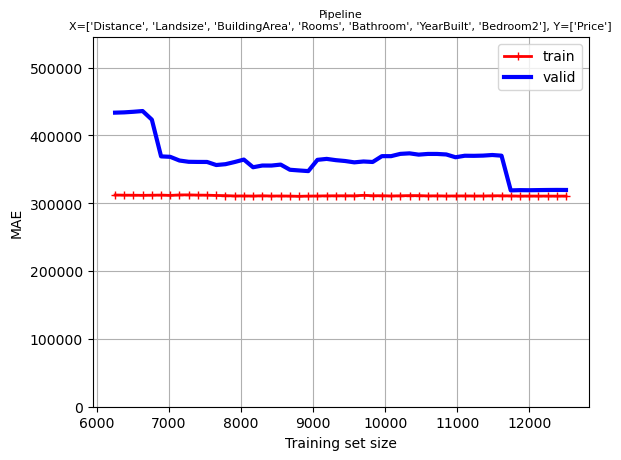

-------
 Polynomial degree: 3 :
For this data-point {'Distance': 5.5, 'Landsize': 573.0, 'BuildingArea': 186.0, 'Rooms': 4.0, 'Bathroom': 2.0, 'YearBuilt': 1890.0, 'Bedroom2': 5.0} in the Price prediction (estimate) had an AUD $ 6,937.40 (error)
Test: mean_absolute_error: 365,524.63
Test: r2_score: -5.20
Train: mean_absolute_error: 299,670.25
Train: r2_score: 0.51
----------------
Has  120 parameters
Has  7 features


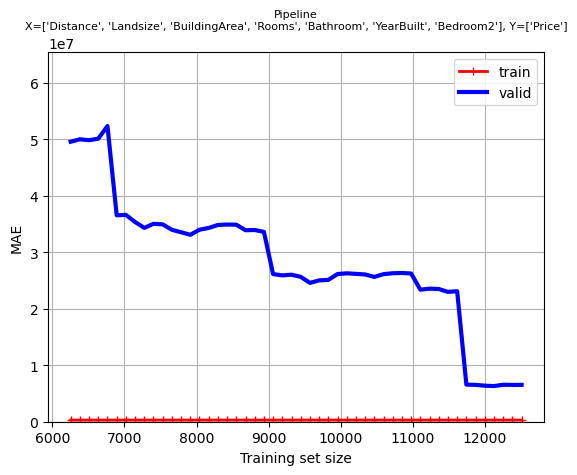

In [76]:
for i in range(1,4):
    print('-------\n Polynomial degree:',i,':')
    pip = _eval_poly_degree(i, features+['YearBuilt','Bedroom2'], target)
    _plot_learning_curve_poly1( pip, X_train, y_train, plt_text=f"X={features+['YearBuilt','Bedroom2']}, Y={target}" )
    plt.show()

* `Negative R2 score` means the model is performing `worse than predicting the mean Price`.
* It also gets slower and slower as we increase the polynomial degree, and its number of parameters.
* By increasing the parameters the training data is fitting better. So it's partly helpful. But we need a better solution.
* This is why we use smarter algorithms to `prevent overfitting` while improving `generalized fit` (on train and test) by `regularizing` the parameters. (More on this in later topics).

## 9. Concluding:

Improving `feature representations` using Polynomial equations increased the number of model parameters and the estimator function's expressiveness to the data, which improved the training set performance, but weakened the test set.

It `overfitted our training data`, which can see via the learning curves.

Therefore we need to choose smart algorithms when we `complexify` (which you will do shortly).

In `Lab 07 Assignment` you will use a smarter (more sophisticated) algorithm to model and predict the data.

<p style="text-align:center;">That's it! Congratulations! <br> 
    Let's now work on your lab assigment.</p>

## 10. Extras - When to Scale Features?

❌  If `interpretation in original units` is important → No scaling. 
* **`Feature Intepretation is useful to explain the behaviour of each feature, according to the model and its error.`**
    * In this case, coefficients show real-world impact per unit increase.
    * If we did not rescale the features, equal unit changes to `Landsize` (meters-sq) and `Bathrooms` (qty) will have unequal unit-effects (magnitudinal effects) on the prediction values.
    * This is fine if we want to `explain`/ `interpret` the coefficients of each feature. I.e. - `how much does an extra bathroom cost, according to the model?`
    * We can see this clearly in the coefficients.
    * For this week's new models, `intercept` is also very different; starting value of `200k AUD-$` instead of `1,000,000 AUD-$` (as last week).

✅ If comparing `feature importance` is the goal → Use StandardScaler. 
* **`Feature Importance is useful to select the best features in order to improve model performance.`**
    * *We know how to do that (`Hint: Lab 05`).*
    * In this case, coefficients are in `standard deviation units`. A value of 1 is equal to 1 standard deviation from mean. That unit value (1) is equal across all features, making them comparable.
    * `StandardScaler` transforms each numeric feature as `mean = 0, variance = 1`.
    * If `# Bedrooms` standard deviation is 1 (e.g. range 1-3, mean is 2), and `Landsize` std is 50 (range 20-100, mean is 50), their 1-std value change becomes equivalent.
    * We can also use the sklearn's `Pipeline` to "magically" manage this for us.
* How that works:
    * First, we `.fit_transform(..)` on the `X_Train` dataset.
    * Then we apply that fitted transform function (which only knows about our `training data`) using `.transform(...)`, to the `X_test` (our testing dataset).
    * If we want to predict a `new input` later (unseen, i.e. you decide to type in some values), we also need to apply  `.transform(...)` again to that data, to keep the relative numbers equal.

### 10.1 Example of manually scaling inputs for predictions:

In [ ]:
from sklearn.preprocessing import StandardScaler

X, y = get_some_data( df, ['Distance'], target )
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0) # Split into 85% training and 15% testing data

* Manually transform entire test set:

In [ ]:
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

estimator = _evaluate_estimator_1( LinearRegression(), X_train_scaled, X_test_scaled, y_train, y_test, features )

* Notice, the errors will be the same; but the input values changed.
* The `Y` Value is still in the usual range of `AUD-$` dollars.

(NB: **Very rarely** do we transform the `Y` value, because it is more useful in its original scale.)

* Manually transform 1 input from train set:

In [ ]:
X_new_data = scaler_X.transform( X_train[0].reshape(1, -1) ) # i.e. transform some new input data to predict.
print(X_new_data)
estimator.predict(X_new_data)

* Manually transform 1 new unseen input:

In [ ]:
X_new_data = scaler_X.transform([[ 11.2 ]]) # i.e. transform some new input data to predict.
print(X_new_data)
estimator.predict(X_new_data)